Initialize path to this github repository:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

Load the required modules and configure theano settings:

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi
import seaborn as sns
import diffxpy.api as de
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


Load data from our NanostringWTA run:

In [3]:
adata_wta = pickle.load(open(path + "data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In this NanostringWTA run we profiled two 19pcw fetal brain cases (one of them with two sections as technical replicates), as well as one 14pcw case. We focussed on the cortex and arranged our ROIs to track neuronal differentiation trajectories from the ventricles on the inside to the cortical plate on the outside of the brain. We call this inside to outside dimension cortical depth. We used both large ROIs as shown in the image below:

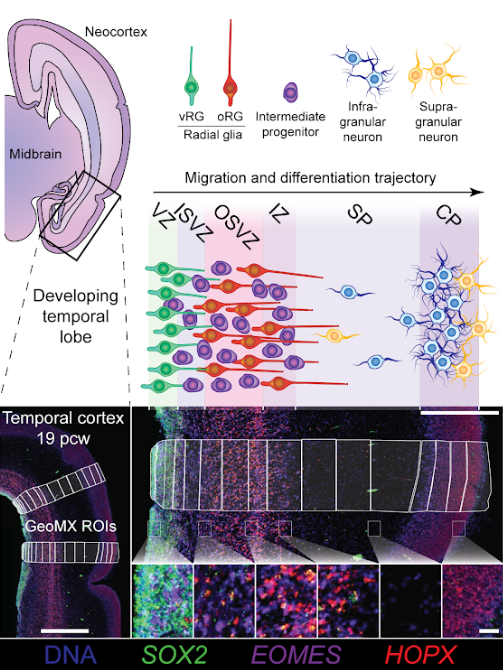

In [4]:
Image(filename='images/GeometricROIs.PNG')

As well as cell type specific areas of interest (AOIs) as shown in this image:

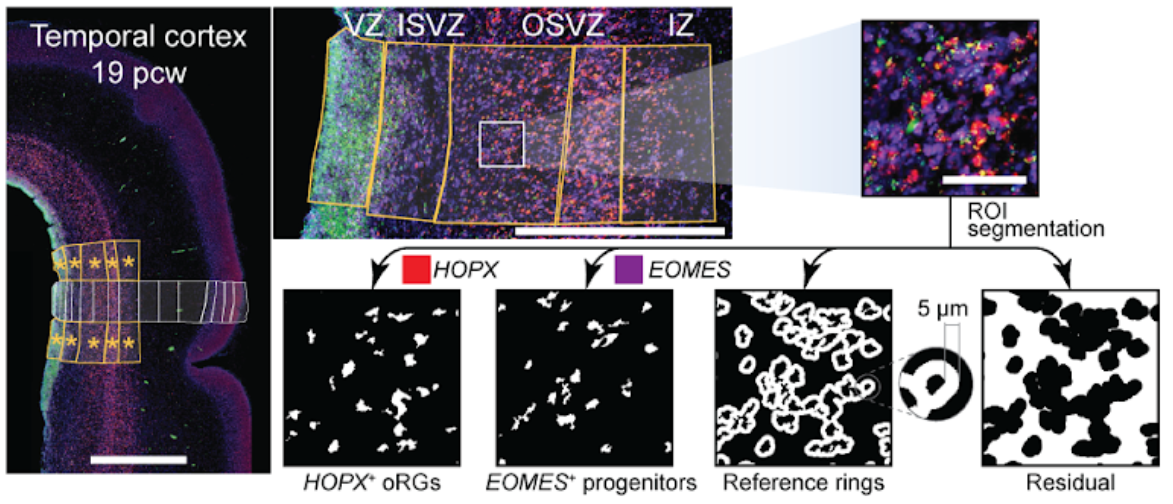

In [5]:
Image(filename='images/CellTypeSpecificAOIs.PNG')

We have already annotated ROIs/AOIs as good or low quality based on a read per nuclei count above 2000 and we do not use low quality ROIs/AOIs in the analysis here:

In [6]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

This histogram shows the range of nuclei counts we have in our ROIs/AOIs:

Text(0.5, 1.0, 'Number of Nuclei in ROIs')

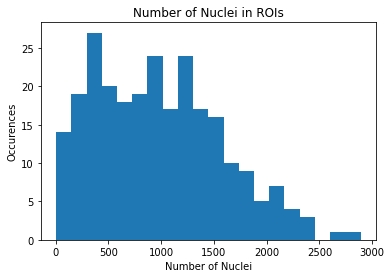

In [7]:
counts_nuclei = np.asarray(adata_wta.obs['nuclei']).reshape(len(adata_wta.obs['nuclei']),1)
plt.hist(counts_nuclei, bins = 20)
plt.xlabel('Number of Nuclei')
plt.ylabel('Occurences')
plt.title('Number of Nuclei in ROIs')

We took those ROIs at different positions across the temporal cortex (cortical depth), with a focus on the ventricular and subventricular zone at low cortical depth, where we also collected cell type specific areas of interest:

Text(0.5, 1.0, 'Number of ROIs at different Cortical Depth')

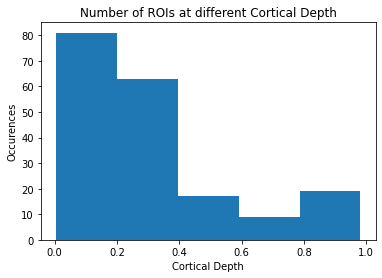

In [8]:
plt.hist(adata_wta.obs['VCDepth'], bins = 5)
plt.xlabel('Cortical Depth')
plt.ylabel('Occurences')
plt.title('Number of ROIs at different Cortical Depth')

The majority of our ROIs/AOIs comes from two 19pcw cases, but we also have a 14pcw case:

Text(0.5, 1.0, 'Number of ROIs per Gestational Age')

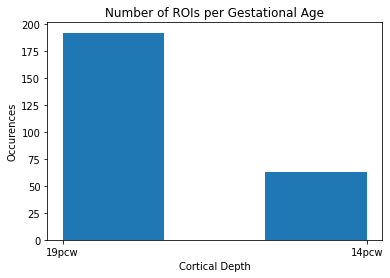

In [9]:
plt.hist(adata_wta.obs['age'], bins = 3)
plt.xlabel('Cortical Depth')
plt.ylabel('Occurences')
plt.title('Number of ROIs per Gestational Age')

There is currently no good way to account for batch effects in our model. Hence, we recommend fitting seperate models to seperate batches. In this analysis we only consider one section:

In [10]:
rSlides = ('00MU')

subset = np.where([adata_wta.obs['slide'][i] in rSlides and adata_wta.obs['Radial_position'][i] in (1,2,3)
                   and adata_wta.obs['AOI_type'][i] in ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')
                            for i in range(len(adata_wta.obs['slide']))])[0]

adata_wta = adata_wta[subset]
np.shape(adata_wta)

(56, 18454)

The generative model that we use for NanostringWTA data, decomposes the counts for each gene probe into two parts: one that corresponds to real expression and one that corresponds to measurement noise, which in NanostringWTA data is non-specific binding of probes and sampling noise. To further constrain the real expression, we project it into a low dimensional space of by default 30 positive components (the number of components can be changed, but we have not found a large effect on performance, unless the number is very small. i.e. below 10). A simple summary of the model, showing all parameters and for some parameters also their prior distributions is shown below. Going through this in detail is not necessary for understanding the rest of the notebook and is just shown here for completeness.

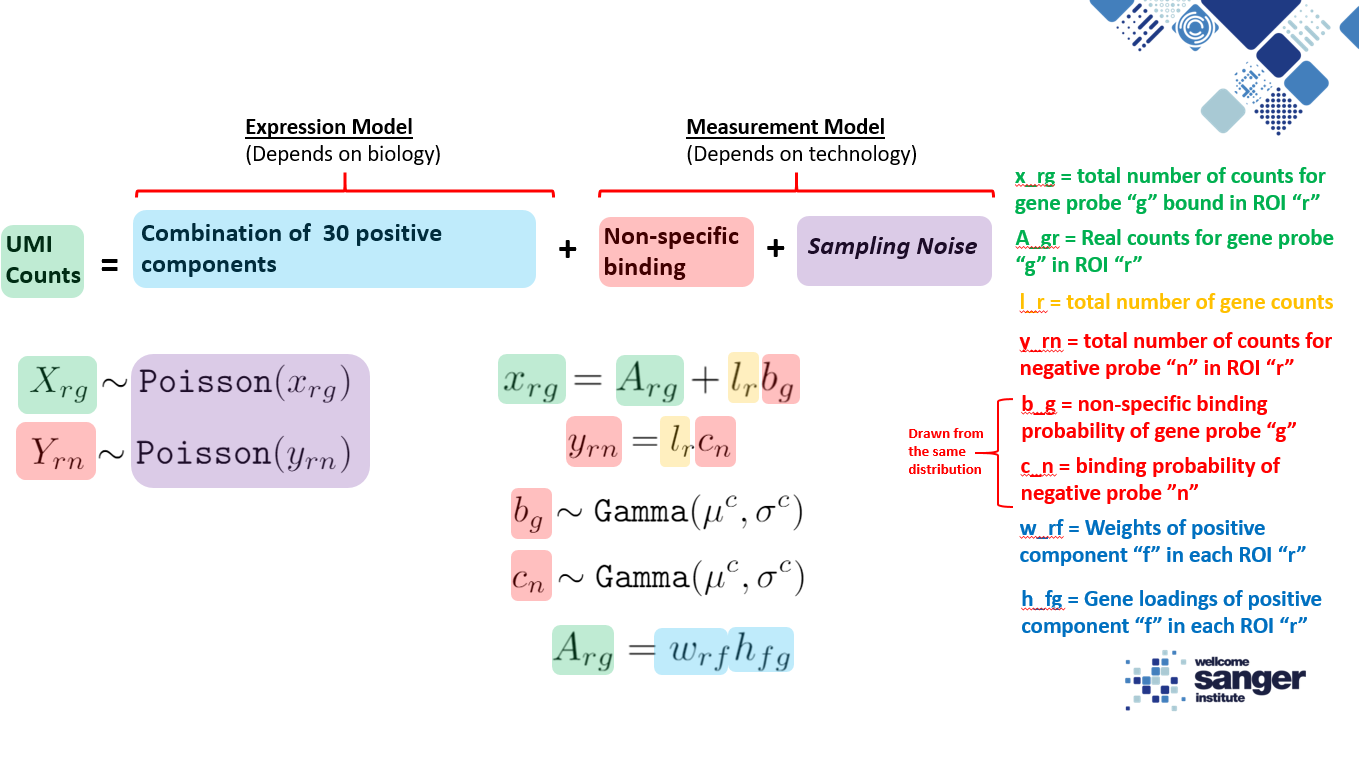

In [11]:
Image(filename='images/ProbeCounts_GeneralModel_V1.PNG')

The model needs seperate gene probes and negative probes in two numpy arrays. We initialize them here:

In [12]:
counts_geneProbes = np.asarray(adata_wta[:,np.array(adata_wta.var != 'NegProbe-WTX').squeeze()].X)
counts_negativeProbes = np.asarray(adata_wta[:,np.array(adata_wta.var == 'NegProbe-WTX').squeeze()].X)

Now we define the model:

In [13]:
mod1 = ProbeCounts_GeneralModel_V1(
        X_data = counts_geneProbes,
        Y_data = counts_negativeProbes,
        var_names = adata_wta.var_names[adata_wta.var_names != 'NegProbe-WTX'],
        n_factors = 30)

And fit the model to our data using automatic differentiation variational inference (advi):

Average Loss = 4.2126e+06: 100%|██████████| 95000/95000 [09:11<00:00, 172.23it/s]
Finished [100%]: Average Loss = 4.2126e+06


Average Loss = 4.2118e+06: 100%|██████████| 1000/1000 [00:05<00:00, 170.01it/s]
Finished [100%]: Average Loss = 4.2118e+06


Average Loss = 4.2116e+06: 100%|██████████| 1000/1000 [00:05<00:00, 172.30it/s]
Finished [100%]: Average Loss = 4.2116e+06


Average Loss = 4.2117e+06: 100%|██████████| 1000/1000 [00:05<00:00, 171.61it/s]
Finished [100%]: Average Loss = 4.2117e+06


Average Loss = 4.2121e+06: 100%|██████████| 1000/1000 [00:05<00:00, 171.78it/s]
Finished [100%]: Average Loss = 4.2121e+06


Average Loss = 4.2131e+06: 100%|██████████| 1000/1000 [00:05<00:00, 171.32it/s]
Finished [100%]: Average Loss = 4.2131e+06


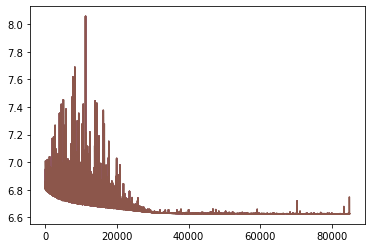

In [14]:
total_iterations = 10**5
mod1.fit_advi_iterative(n_iter = total_iterations - 5000, learning_rate = 0.001, n=1, method='advi')
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.0001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.00001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.000001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.0000001)
mod1.fit_advi_refine(n_iter=1000, learning_rate = 0.00000001)

The optimization history above suggests that the optimization has converged. To confirm this we can also inspect the last 10000 iterations:

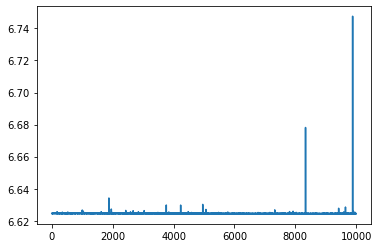

In [15]:
mod1.plot_history(total_iterations - 10000)

We see that the loss is constant in the last 10000 iterations. Overall, this suggests the optimization has really converged.

Now that we fit the model to our data we can get a new count matrix that is corrected for background and sampling noise. To approximate this corrected count matrix we take 1000 samples from the posterior distribution of the model:

In [16]:
mod1.sample_posterior(node='all', n_samples=1000, save_samples=False);

And then compute "X_corrected" as A_gr in the model description above:

In [17]:
ProbeCounts_GeneralModel_V1.compute_X_corrected(mod1)

Importantly the X_corrected values are probability distributions, so we can look both at the mean:

In [18]:
print('mean', mod1.X_corrected_mean)

mean [[ 47.  22. 185. ...  72.  41.  20.]
 [ 30.  46. 114. ...  90.  37.  22.]
 [ 19.  34.  55. ...  19.  19.  10.]
 ...
 [ 17.  35.  52. ...  28.  17.  11.]
 [ 33.  57. 108. ...  43.  35.  19.]
 [ 11.  19.  32. ...  16.  13.   8.]]


And their 90% confidence interval:

In [19]:
print('q05', mod1.X_corrected_q05)
print('q95', mod1.X_corrected_q95)

q05 [[ 38.  14. 171. ...  58.  30.  12.]
 [ 24.  38. 104. ...  79.  29.  14.]
 [ 15.  31.  51. ...  16.  16.   7.]
 ...
 [ 14.  32.  49. ...  25.  14.   8.]
 [ 28.  52. 102. ...  37.  29.  14.]
 [  9.  17.  30. ...  14.  10.   5.]]
q95 [[ 58.  32. 200. ...  90.  54.  32.]
 [ 38.  56. 126. ... 103.  46.  31.]
 [ 24.  37.  58. ...  24.  24.  16.]
 ...
 [ 19.  39.  55. ...  32.  21.  14.]
 [ 38.  63. 115. ...  50.  42.  26.]
 [ 14.  23.  35. ...  20.  17.  12.]]


We have a plotting function to produce a simple overview of the model behaviour and to compare it to a "naive" model that simply calculates the mean number of negative probe counts in each ROI and subtracts this number from each gene:

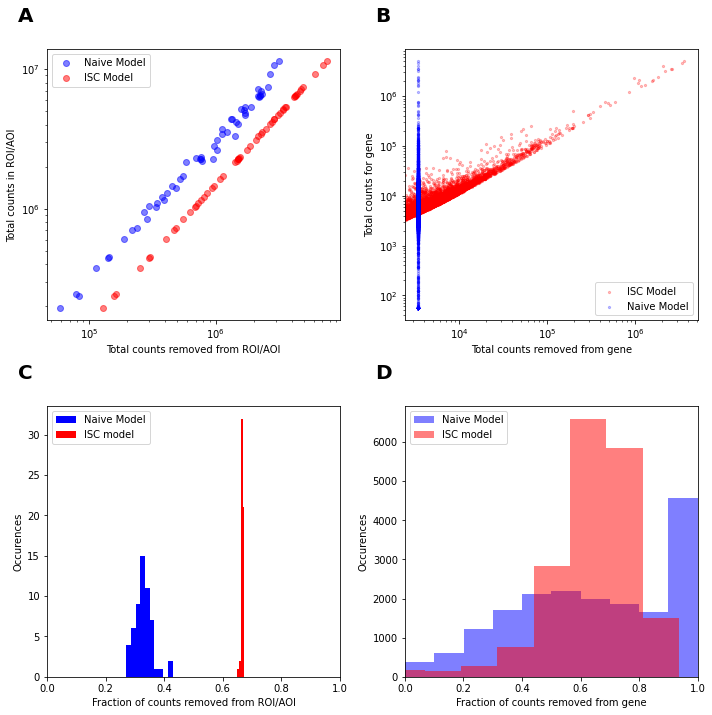

In [20]:
mod1.plot_X_corrected_overview2()

Also make the plot D alone without the Naive model:

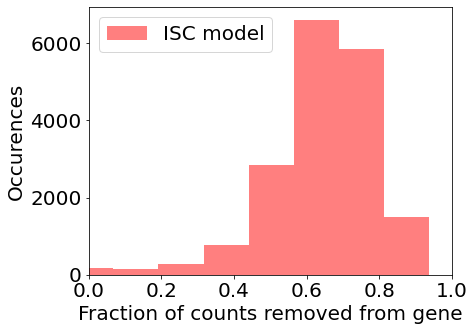

In [21]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
ProbeCounts_GeneralModel_V1.plot_X_corrected_overview3(mod1, saveFig = 'Figure2C_FractionRemoved.pdf')

In figure A we see in red that our model expects the number of background counts to scale linearly with the total number of counts in an ROI/AOI. This agrees with the negative probe data, where the mean counts of negative probes scale linearly with the total gene probe counts as shown in blue. If there were some blue dots that strongly deviate from this linear relationship this would suggest some ROIs/AOIs with particularly high background which our model does not account for, but in this dataset we do not see any of this. In addition, we see that our model removes more background counts than would be expected from the average negative probe counts. This could be because of some outlier probes the model identifies with an extremely high background. Figure C makes the same point, but shown as a historgram of the fraction of removed counts from each ROI/AOIs. The width of the blue distribution, thus shows to what extent it fits a linear relationship and the difference between the blue and red distribution, shows how much more counts our model removes compared to the expectation from negative probe counts alone.

In figure B we see one of the main difference between our model and the naive approach. If we just remove the mean negative probe count from each gene then we assume a constant background for each gene, as shown by the vertical blue line. In contrast to this, our model calculates a gene specific measurment noise, as shown in red. This shows that many genes are predicted to have less background than the mean negative probe counts, but many genes are also far above the mean negative probe count. Figure D shows the distribution of the fraction of counts removed from each gene. A problem with our current approach could be that the model never removes 100% of the counts.

If only one overview function for the model behaviour is desired this figure is a good summary:

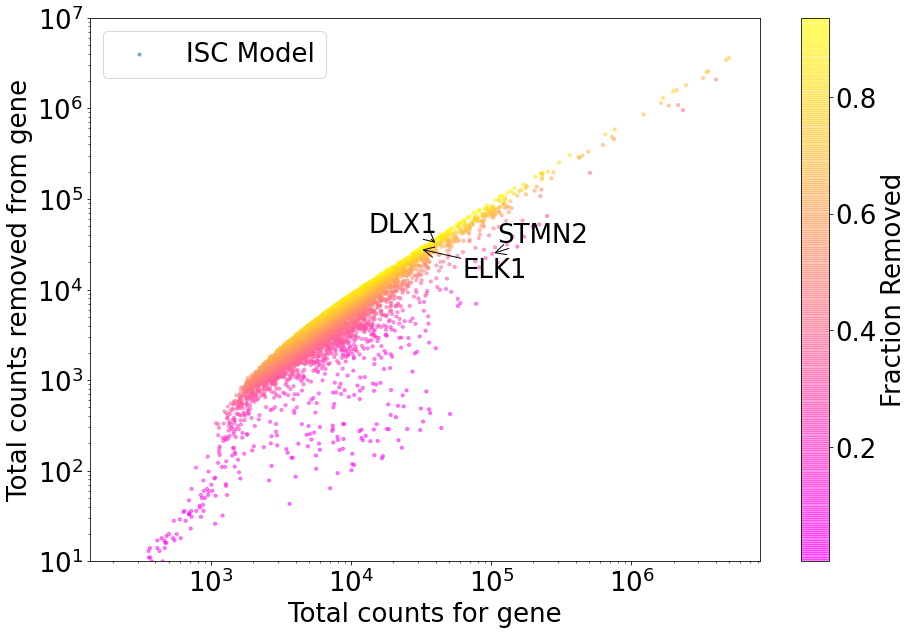

In [22]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1

genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))

ProbeCounts_GeneralModel_V1.plot_X_corrected_overview1(mod1, genesOfInterest, cmap = 'spring', saveFig = 'Figure2B_ModelOverview_Cmap-summer.pdf')

We can also rank genes by what percentage of counts were removed from them:

In [23]:
rankedGenes = mod1.rank_X_corrected_genes()
rankedGenes

Gene  Total Counts  Removed Counts  \
EGFL8                  EGFL8         74983           70181   
ATRX                    ATRX         43958           41116   
ZNF808,ZNF600  ZNF808,ZNF600         75811           70482   
SERPINB3            SERPINB3         81446           75660   
PRRC2B                PRRC2B         31618           29255   
...                      ...           ...             ...   
CCDC63                CCDC63            56             -16   
DR1                      DR1            56             -16   
CPE                      CPE            56             -16   
PMAIP1                PMAIP1            57             -17   
SLC31A1              SLC31A1            56             -17   

               Fraction Removed Counts (Mean)  Fraction Removed Counts (q05)  \
EGFL8                                0.935959                       0.947308   
ATRX                                 0.935347                       0.951840   
ZNF808,ZNF600                        0.929707                       0.943095   
SERPINB3                             0.928959                       0.940525   
PRRC2B                               0.925264                       0.943165   
...                                       ...                            ...   
CCDC63                              -0.285714                       0.339286   
DR1                                 -0.285714                       0.375000   
CPE                                 -0.285714                       0.303571   
PMAIP1                              -0.298246                       0.280702   
SLC31A1                             -0.303571                       0.303571   

               Fraction Removed Counts (q95)  
EGFL8                               0.921369  
ATRX                                0.914191  
ZNF808,ZNF600                       0.913469  
SERPINB3                            0.913427  
PRRC2B                              0.901101  
...                                      ...  
CCDC63                             -1.214286  
DR1                                -1.196429  
CPE                                -1.214286  
PMAIP1                             -1.175439  
SLC31A1                            -1.250000  

[18317 rows x 6 columns]

Let's gather the top 3 genes with most removed counts and put them in a list with a few well known cell type markers. Then let's look up this list of genes in the scRNAseq study by Polioudakis et al., Neuron 2019, to check how cell types in the fetal brain express those genes:

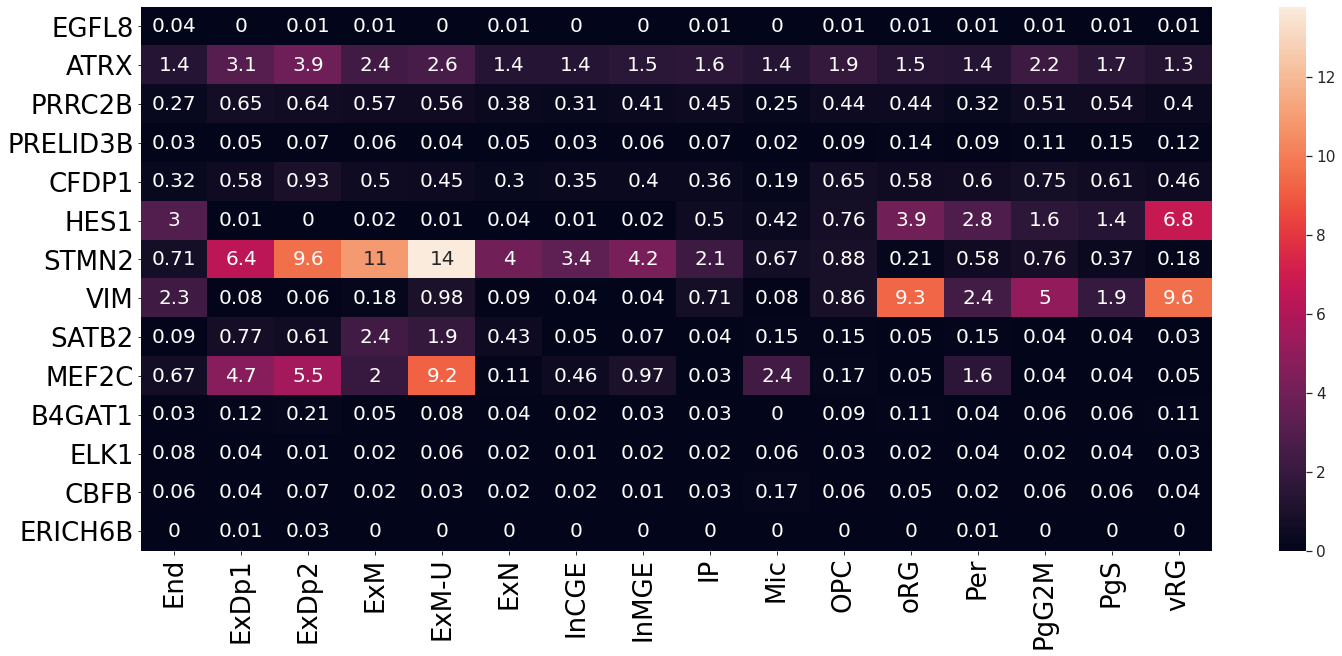

In [24]:
# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
topGenes = commonGenes[0:5]
celltypeMarkers = np.array(('HES1', 'STMN2','VIM', 'SATB2', 'MEF2C', 'B4GAT1', 'ELK1', 'CBFB', 'ERICH6B'))
lookup_genes = np.concatenate([topGenes, celltypeMarkers])

# Plot cell type specific expression of genes:
fig, ax = plt.subplots(figsize=(24,10))
sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression_sc.loc[lookup_genes,:],2), annot = True,  annot_kws={"size": 20})

Excluding ATRX, the genes with many removed counts are not supposed to be expressed in the fetal brain at a high level at all, yet they have more total counts than some of our cell type markers, which we can see by inspecting the rankedGenes dataframe:

In [25]:
rankedGenes.loc[[rankedGenes['Gene'].iloc[i] in lookup_genes for i in range(len(rankedGenes['Gene']))],:]

Gene  Total Counts  Removed Counts  \
EGFL8        EGFL8         74983           70181   
ATRX          ATRX         43958           41116   
PRRC2B      PRRC2B         31618           29255   
PRELID3B  PRELID3B         57426           52810   
CFDP1        CFDP1         27887           25623   
ELK1          ELK1         31197           27900   
CBFB          CBFB       4994213         3589793   
B4GAT1      B4GAT1          9031            6451   
HES1          HES1          8944            3741   
STMN2        STMN2        101465           24847   
ERICH6B    ERICH6B          1355             242   
VIM            VIM         36623             433   
MEF2C        MEF2C         32567             349   
SATB2        SATB2         50766             423   

          Fraction Removed Counts (Mean)  Fraction Removed Counts (q05)  \
EGFL8                           0.935959                       0.947308   
ATRX                            0.935347                       0.951840   
PRRC2B                          0.925264                       0.943165   
PRELID3B                        0.919618                       0.934298   
CFDP1                           0.918815                       0.939147   
ELK1                            0.894317                       0.915216   
CBFB                            0.718791                       0.721252   
B4GAT1                          0.714317                       0.760049   
HES1                            0.418269                       0.466123   
STMN2                           0.244882                       0.259932   
ERICH6B                         0.178598                       0.308487   
VIM                             0.011823                       0.037217   
MEF2C                           0.010716                       0.035957   
SATB2                           0.008332                       0.029685   

          Fraction Removed Counts (q95)  
EGFL8                          0.921369  
ATRX                           0.914191  
PRRC2B                         0.901101  
PRELID3B                       0.901369  
CFDP1                          0.892459  
ELK1                           0.867231  
CBFB                           0.716073  
B4GAT1                         0.659395  
HES1                           0.362589  
STMN2                          0.228522  
ERICH6B                        0.016974  
VIM                           -0.014581  
MEF2C                         -0.016950  
SATB2                         -0.014458

Hence the model likely correctly identified faulty probes with an excessive number of non-specific binding events.

One weakness of the current model seems to be that it never identifies 100% of the counts as measurement noise (one of the disadvantages of non-negative matrix factorization used for A_rg in the model is that values don't tend to go to 0). Hence, all genes still have at least 1 count. To determine, which genes are detected in a given ROI/AOI, we thus need to choose an arbitrary cutoff, which we choose at 50 counts for now. This roughly matches the number of detected genes we get by using the limit of detection provided by the Nanostring software, as shown in the following plot, that illustrates the number of detected genes per ROI across cortical depth:

In [26]:
absolute_cutoff = 50
ProbeCounts_GeneralModel_V1.compute_X_detected(mod1, absolute_cutoff)
print('X_detected', mod1.X_detected)

X_detected [[0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [27]:
x = np.asarray(adata_wta.obs['VCDepth'])
order = np.where([adata_wta.obs['Radial_position'][i] == 2 for i in range(len(adata_wta.obs['Radial_position']))])[0]
nuclei = np.asarray(adata_wta.obs['nuclei'])
LoD_cutoff = adata_wta.obs['GeoLOD2.5_01']

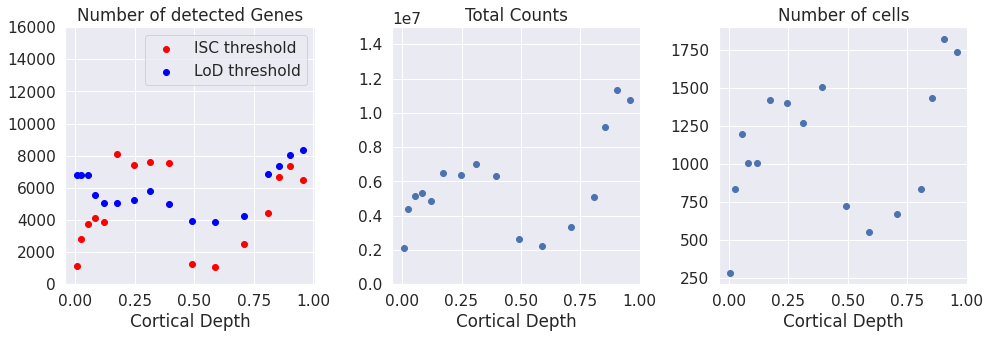

In [28]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
ProbeCounts_GeneralModel_V1.plot_X_detected(mod1, x, order, nuclei, LoD_cutoff, xlabel = 'Cortical Depth', saveFig = 'DetectedGenes.pdf')